# Assignment 4

Due Thu, Apr 06 (23:59pm), commited to your `phys248` repo on the Abacus GitLab server. 

Problem 1 requires Lab 11.2, Problem 2 requires Lecture 11.2. Start with Problem 3 and 4. 

As part of this assignment you need to add some files you produce. Add these directly to your `Exam_Assignment_Quiz` along with your copy of this Assignment notebook. Do not change the name of the notebook, and make sure you only have one Assignment 4 notebook file in your repo. Do add the required files with the name exactly as specified.

## Problem 1
Solve the network from Lab 11.1 along a trajectory (see Lab 11.2), i.e the time evolution of T which you will use as input. Use the same value for $\rho$ as in Lab 11.1. Follow these steps:

1. Read the time and temperature data from the file `T-evol.dat` but reverse the time direction. That means, read time and temperature arrays but then **reverse the direction of the temperature array using array slicing**. Make a plot of $T_9$ vs. $\log t$. $T_9$ (`T9`) is temperature in units of $10^9\mathrm{K}$.
2. Create a linear interpolation function called `get_T9` that returns the temperature as `T9` from an input of time in seconds. Test the function by overplotting a few points to the plot of part 2.1. Test the function `get_rates` by making a plot of the four rates as a function of `T9` in the range of temperatures covered in the trajectory file, and as a function of time covered in the trajectory. 
3. Modify function `react_terms` from Lab 11.1 (and call it `react_terms_t`) in two ways. It should use the `get_rates` subroutine from Lab 11.2 Activity 2 and it should take a molar abundance vector `Y` as well as the time in seconds as input. Then it needs to use `get_T9` to  get the temperature for the given time, and then the rates for the temperature obtained using the `get_rates` function. Use the code from Lab 11.1 Activity 1 to read the initial abundances. Test your function `react_terms_t`.
4. Create a modified version of `f_rhs` called `f_rhs_yt` that uses `react_terms_t` and solve the system of network ODEs for the range of $t \in [0.1,10^{4.6}]$. Plot the evolution of all species mass fractions over `log10` of the time, and make sure that the  time resolution for plotting the results is about 0.02 dex. Use appropriate spacing of glyphs. 
5. Investigate your solution. One species has a maximum during the evolution. Which one and at which time? One species has a minimum? Which one and at which time?

In [ ]:
%pylab ipympl

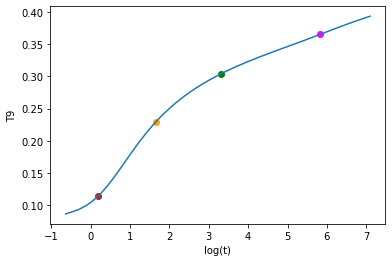

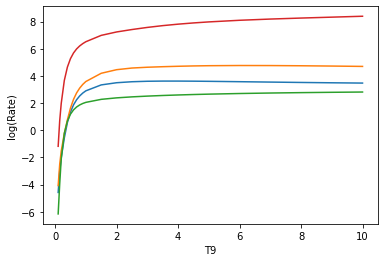

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

# 1
t, T= np.loadtxt("T-evol.dat", unpack=True) # time and temperature
T = T[::-1]

plt.ylabel('T9')
plt.xlabel('log(t)')
plt.plot(np.log10(t[1:-1]), T[1:-1])

# 2 create interpolation
def get_T9(t, T):
    return interp1d(np.log10(t[1:-1]), T[1:-1], kind='linear')

T9 = get_T9(t, T)
plt.scatter(3.309, T9(3.309), color='green')
plt.scatter(1.662, T9(1.662), color='orange')
plt.scatter(0.189, T9(0.189), color='brown')
plt.scatter(5.821, T9(5.821), color='magenta')
plt.show()

# test get_rates()
rate_list = []
files = ['c12pg.txt','c13pg.txt','n14pg.txt','n15pa.txt']
for i in files:
    Tmp, rates = np.loadtxt('../Data/'+i, unpack=True)
    rate_list.append(interp1d(Tmp, np.log10(rates)))

def get_rates(Tmp, rate_list):
    ans = []
    for T9, rate in enumerate(rate_list):
        func = []
        for temp in Tmp:
            func.append(rate_list[T9](float(temp)))
        ans.append(func)
    return ans

rates = get_rates(Tmp, rate_list)
plt.xlabel('T9')
plt.ylabel('log(Rate)')
for i in range(4):
    plt.plot(Tmp, rates[i])
plt.show()

# 3 
numProton, element, sumProtonElec, massFrac = np.loadtxt("../Data/iniab1.4E-02As09.ppn", dtype='str', unpack=True)
Y = [float(massFrac[i])/float(sumProtonElec[i]) for i in range(len(massFrac))]
#print(Y)

def react_terms(Y, rates):
    res = []
    for i in range(4):
        #print(np.array(rates[i]))
        cur = np.array(rates[i])*float(Y[0])*float(Y[i+2])
        res.append(cur)
    return res

term = react_terms(Y, rates)

# 4
def f_rhs(Y, rates, term):
    rhs = [-term[0]-term[1]-term[2]-term[3],
            term[3],
            -term[0]+term[3], 
            term[0]-term[1],
            term[1]-term[2],
            term[2]-term[3],]
    return rhs

t = np.linspace(-1, 4.6)
func = lambda t, Y: f_rhs(Y, rates, term)
#ode = solve_ivp(func, t_span=(-1, 4.6), y0=Y, method="Radau", t_eval=t)

# Problem 2

Search for the global minimum of a function. Consider the function $f(x) = 0.4x^4 +0.2x^3 - 2.5x^2 - \cos(4 \pi x)$

1. Make a plot of the function for $x\in[-3.1,2.9]$. The global minimum is clearly near $x\approx -2$.
2. Confirm this fact by searching for the global mimum using simulated annealing. Start with $x_\mathrm{ini} = 1.5$ with moves (neighbour function) that replace $x \rightarrow x+\delta$ where $\delta$ is a random number drawn from a Gaussian distribution with mean zero and standard deviation $\sigma$. Use an exponential cooling schedule of the form $T =  a \exp(-bt)$ with $t \in [0,t_\mathrm{end}]$. 
3. Using some guesses for $\sigma$, $a$, $b$ and $t_\mathrm{end}$ make a plot of all $x$ values as a function of step number with markers only. Add the $x$ values that have been used for an update (those $x'$ for which $P(x',x,T) >= random()$).
4. Use this plot to systematically adjust the parameters $\sigma$, $a$, $b$ and $t_\mathrm{end}$ until you find values that give good answers in the smallest number of steps (the number of steps are the number of intervals of $t$). A good choice of parameters should reliable give the correct answer each of 10 subsequent attempts.
5. Make a plot called `global-minimum.png` and commit that along with your solution notebook. 

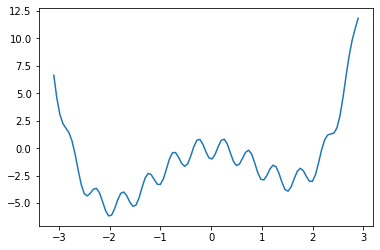

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

x = np.linspace(-3.1, 2.9, 101)

f = lambda x: 0.4*x**4+0.2*x**3-2.5*x**2-np.cos(4*np.pi*x)
plt.plot(x, f(x))

# set up exponential cooling schedule
a = 0.5
b = 1
tend = 3
t = np.linspace(0, tend)
T = lambda t: a*np.e**(-b*t)
# plt.plot(t, T(t))

# gennerate gaussian
x = 1.5
kmax = 1000
for i in range(kmax):
    Tmp = T((i+1)/kmax)
    dx = random.normal()
    x += dx
    #print(f'{Tmp}, {x}')

## Problem 3

### 3.1
Visualize the Recaman sequence up to $n=66$ by plotting a half-circle between $a_n$ and $a_{n-1}$ below the number ray for $n$ uneven and above for $n$ even. Plot each half circle a different color increasing with $n$ along a continuous color map of your choosing. 
 
Submit image with name `racaman-66.png`  to your `Exam_Assignment_Quiz` folder.

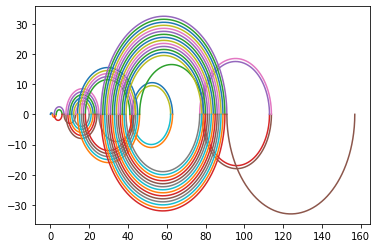

In [33]:
import numpy as np
import matplotlib.pyplot as plt

n = 66
x = np.linspace(0, n, n+1)
val = [0]
for i in range(1, n+1):
    if val[i-1]-i > 0 and val[i-1]-i not in val:
        val.append(val[i-1]-i)
    else:
        val.append(val[i-1]+i)

def plot_arc(an, an_, n):
    center = (an + an_)/2.
    radius = abs(an - an_)/2
    x = np.linspace(-radius,radius,1000)
    y = np.sqrt(radius**2 - x**2) * (-1)**n
    plt.plot(x+center,y)
    
for i in range(1, n+1):
    plot_arc(val[i], val[i-1], i-1)

plt.savefig('racaman-66.png')
plt.show()

### 3.2

In Lab 10.1 Activity 1 you have calculated the Recaman sequence up to $n=198$. Create a wav file called `recaman-100.wav` that represents the audification of this sequence up to $n=100$.  Use the function $f(n) = f_0  2^{n/36}$ with $f_0 = 466.16/6$ to map the integer numbers of the sequence to frequencies. Use a sampling rate of $8192$ and make each tone $0.2\mathrm{s}$ long. To test your audio file play a version with a bit longer tone length (e.g. $0.4\mathrm{s}$) and follow along the figure you created in Lab 10.2 Activitiy 1 (the _music score_) to see if you recognize the Recaman melodie.

Note: Make a plot of the frequency mapping function $f_0$ for the range of integer values that the Recaman series assumes up to $n=100$ to convince yourself that the sampling rate is just barely sufficient to cover the highest-pitch tones.  

Check the size of your `recaman-100.wav`. It should be well below 1MB. Add the file to your `Exam_Assignment_Quiz` folder.

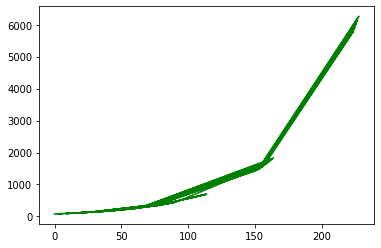

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio

n = 100
an = [0]
sample_rate = 8192

for i in range(1, n+1):
    if an[i-1]-i > 0 and an[i-1]-i not in an:
        an.append(an[i-1]-i)
    else:
        an.append(an[i-1]+i)

an = np.array(an)
f = lambda an: f0*2**(an/36)
fn = f(an)
ns = 0.2
plt.plot(an, fn, color='green')
plt.show()
wavfile.write('racaman-100.wav', 8192, fn)
Audio('racaman-100.wav')

## Problem 4

### 4.1
Using your work from Lab 10.1 Activity 2 establish a relationship between the boundary width expressed in the standard deviation of the Gauss fit of the radial derivative of the concentration (see class 10.2) and the grid resolution.
1. Create a list of cases with heating factor (`X_Lfactors`) equal to 1000. They all have the time `1360` hours, and there are four of them. Don't create this list by hand, but write code that finds these and arranges the case labels in a list.
2. Write a loop in which each resolution case is fitted with a Gaussian. Record the sigmas and the grid values in two lists called `sigmas` and `grids`.
3. Make log-log plot of the `sigmas` vs `grids`. Interpret the graph in terms of the convergence properties of this metric under grid resolution. What is the _true_ or accurate boundary width?

sigmas: [6.604271731889077, 8.345846283079696, 11.606355801621909, 14.907280736367413]
grids: [2688, 1728, 1152, 768]


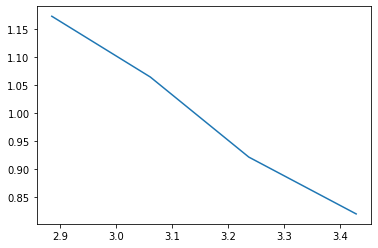

In [58]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

f = open("../Labs/10.1_Lab/data-Pgas-bndry-analysis.pkl", "rb")
data = pickle.load(f)

res = []
sigmas = []
grids = []
X_Lfactors = 1000
t = 1360
for i in data:
    if data[i]['X_Lfactors']-X_Lfactors < 0.01:
        res.append(data[i])

for i in res:
    R = i[1360]['R']
    FV = i[1360]['FVcld']
    dFdR = np.gradient(FV, R)
    ind = np.where(dFdR > 0.5*max(dFdR))
    a = 0.035
    b = 1500
    c = 20
    p0 = (a, b, c)
    
    def gauss(x, a, mu, sigma):
        return a*np.exp(-1*((x-mu)**2)/(2*sigma**2))
    sol, __ = curve_fit(gauss, R[ind], dFdR[ind], p0=p0)
    sigmas.append(sol[2])
    grids.append(i['grids'])

print(f"sigmas: {sigmas}")
print(f"grids: {grids}")

plt.plot(np.log10(grids), np.log10(sigmas))
plt.show()


### 4.2
Recall that data sets are given for each `case` and that for some cases there is a profile for more than one time. The following case and time combinations constitute a sequence of profiles for different luminosities or convection driving strength and similar mass-entrainment rates (i.e. the location of the peak in `grad(FV)` should approximately be at the same radius). The different luminosities are expressed in terms of factors to the nominal heating which represents the heating in a global model that represents best the luminosity in the actual star.

```Python
L_cases=[('M114',4200),('M119',1200),('M118',350)]
for i,(case,time) in enumerate(L_cases):
    print(f"data keys case: {case} and time: {time}")
```

1. Make a plot of the gradient of `FV` as a function of `R` for all three cases and convince yourself that the peak is approximately at the same location. 
2. Again, determine the $\sigma$ for each of the three cases of the luminosity sequence.
3. Fit the log-log data with a linear relation. What is the proportionality constant (which is of course the exponent of the power law describing the relation). Using $\sigma(grid=2688)$ for the luminosity case $1000$ times the nominal heating, and using the power law exponent from the linear fit, what is the estimate of the boundary width for nominal heating? 

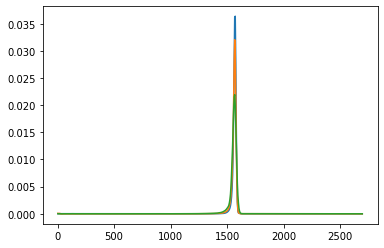

2. sigmas for 3 cases: [8.993912639923332, 10.28523624343408, 15.625829324301167]


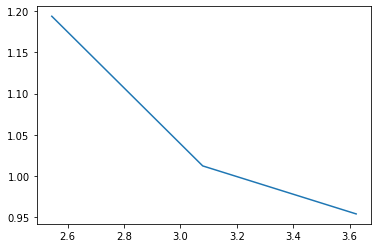

In [67]:
L_cases=[('M114',4200),('M119',1200),('M118',350)]
sigmas = []
grids = []
for i,(case,time) in enumerate(L_cases):
    FV = data[case][time]['FVcld']
    R = data[case][time]['R']
    dFdR = np.gradient(FV, R)
    plt.plot(R, dFdR)
    
    ind = np.where(dFdR > 0.5*max(dFdR))
    a = 0.020
    b = 1500
    c = 40
    p0 = (a, b, c)
    sol, __ = curve_fit(gauss, R[ind], dFdR[ind], p0=p0)
    sigmas.append(sol[2])
    grids.append(time)
plt.show()

print(f'2. sigmas for 3 cases: {sigmas}')

plt.plot(np.log10(grids), np.log10(sigmas))
plt.show()